<a href="https://colab.research.google.com/github/snickerphudle/FutureMakers2021/blob/main/Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mount google drive to google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path
# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#constants

NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 20  # Maximum number of words in a sequence

In [ ]:
#read the Tweets.csv data from google drive
df = pd.read_csv('/content/drive/MyDrive/Work Programs/2021/SureStart Deep Learning/Twitter Data/input/Tweets.csv')

In [ ]:
df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
#lots of unnecessary data
#remove: tweetid, airline, name, retweet, creation date, tweet coordination, location, timezone
#df.drop(['tweet_id', 'airline', 'name', 'retweet_count', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone'], axis = 1)

df = df[['text', 'airline_sentiment']]
df.head(5)

,text,airline_sentiment
1566,@united is the worst airlines sitting on the p...,negative
12373,@AmericanAir zoom in on the sauce and potatoe...,negative
7172,@JetBlue what else on this plane is duct-taped...,negative
10078,"@USAirways, I know you're dealing with the wea...",negative
727,@united thanks United I understand that. But h...,negative


Helper Functions

In [ ]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history
def eval_metric(model, history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, NB_START_EPOCHS + 1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    print()
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results
    
def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)
def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
    '''
    Function to compare a metric between two models 
    
    Parameters:
        model_hist_1 : training history of model 1
        model_hist_2 : training history of model 2
        metrix : metric to compare, loss, acc, val_loss or val_acc
        
    Output:
        plot of metrics of both models
    '''
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]
    e = range(1, NB_START_EPOCHS + 1)
    
    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }
    
    metric_label = metrics_dict[metric]
    plt.plot(e, metric_model_1, 'bo', label=model_1.name)
    plt.plot(e, metric_model_2, 'b', label=model_2.name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()
    
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

In [ ]:
#shuffles the tweets, rows of data
df = df.reindex(np.random.permutation(df.index))  
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)

In [ ]:
#Splits the Data in training and testing
#input, x = tweet
#output, y = airline_sentiment
#10% data -> test set
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)

In [ ]:
X_train[11730]

' would way wether delayed yet again.. Love Charlotte ice storm!! Good luck mad customers'

In [ ]:
#tokenizer used to turn words in a sentence (in the data) into numbers in a vector
#this tokenizer removes punctuation, turns words to lowercase, and splits it by spaces
#puts the words in a dictionary
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n',
               lower=True,
               char_level=False,
               split=' ')

#run the tokenizer on the input data
tk.fit_on_texts(X_train)



In [ ]:
X_train[11730]

' would way wether delayed yet again.. Love Charlotte ice storm!! Good luck mad customers'

In [ ]:
tk.word_index

In [ ]:
#using the dictionary, tk turns the tweets into a matrix
X_train_oh = tk.texts_to_matrix(X_train, mode='binary')
X_test_oh = tk.texts_to_matrix(X_test, mode='binary')

In [ ]:
X_train_oh[11730].shape

(10000,)

In [ ]:
#turns the labels into numbers then uses to categorical for one hot encoding
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [ ]:
#split training into training + validation
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

In [ ]:
#create the base model to see initial performance, then tweak later to make better
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))

Minimum validation loss reached in epoch 3


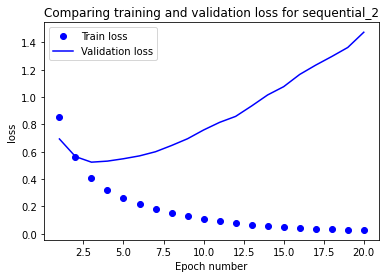

In [ ]:
#running experiments on the model now
#creates a history for the model
base_history = deep_model(base_model, X_train_rest, y_train_rest, X_valid, y_valid)\

#returns epoch with least loss
base_min = optimal_epoch(base_history)

#evaluates the model using matplotlib, function is defined in the beginning
#validation loss reaches a minimum in epoch 3 before going back up
eval_metric(base_model, base_history, 'loss')

Our model is overfitting. How can we overcome this?

1. Reduce layers (more layers = more complex)
2. Dropout (drop some layers randomly)
3. Regularization (more cost to loss function for very large weights)

Minimum validation loss reached in epoch 14


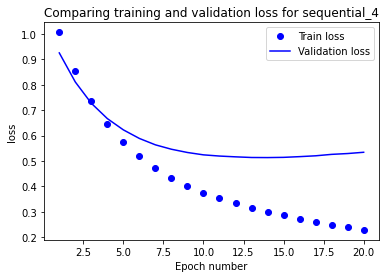

In [ ]:
#new model only has one hidden layer with only 16 nodes
#Reduce layers
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(16, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_history = deep_model(reduced_model, X_train_rest, y_train_rest, X_valid, y_valid)
reduced_min = optimal_epoch(reduced_history)
eval_metric(reduced_model, reduced_history, 'loss')

Minimum validation loss reached in epoch 4


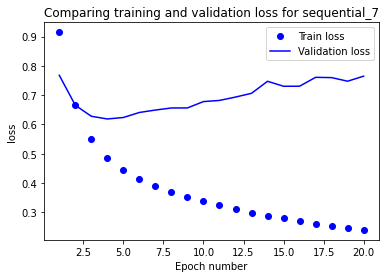

In [ ]:
#Apply Regularization

reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_history = deep_model(reg_model, X_train_rest, y_train_rest, X_valid, y_valid)
reg_min = optimal_epoch(reg_history)
eval_metric(drop_model, reg_history, 'loss')

Minimum validation loss reached in epoch 7


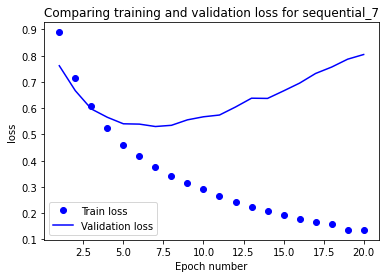

In [ ]:
#dropout
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_history = deep_model(drop_model, X_train_rest, y_train_rest, X_valid, y_valid)
drop_min = optimal_epoch(drop_history)
eval_metric(drop_model, drop_history, 'loss')

In [ ]:
#compare all models to each other
#all methods of reducing overfitting slightly increaess
base_results = test_model(base_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, base_min)
reduced_results = test_model(reduced_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reduced_min)
reg_results = test_model(reg_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reg_min)
drop_results = test_model(drop_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, drop_min)

46/46 [==============================] - 0s 2ms/step - loss: 1.2612 - accuracy: 0.7664

Test accuracy: 76.64%
46/46 [==============================] - 0s 2ms/step - loss: 0.7591 - accuracy: 0.7862

Test accuracy: 78.62%
46/46 [==============================] - 0s 3ms/step - loss: 0.7153 - accuracy: 0.7964

Test accuracy: 79.64%
46/46 [==============================] - 0s 2ms/step - loss: 0.8268 - accuracy: 0.7923

Test accuracy: 79.23%
